### Nonlinear Problems in Finance (MATHGR5400), Columbia University, Spring 2019

### Alexander Chen (yc3528)

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import laguerre
from scipy.interpolate import interp1d
from scipy.stats import norm
plt.rc('figure', figsize=(6, 5))
plt.rc('axes', grid=True, xmargin=0, ymargin=0, autolimit_mode='round_numbers')

# American Option Pricing

In [3]:
def blackscholes_mc(S=100, vol=0.2, r=0, q=0, ts=np.linspace(0, 1, 13), npaths=10):
    """Generate Monte-Carlo paths in Black-Scholes model.

    Parameters
    ----------
    S: scalar
        The spot price of the underlying security.
    vol: scalar
        The implied Black-Scholes volatility.
    r: scalar
        The annualized risk-free interest rate, continuously compounded.
    q: scalar
        The annualized continuous dividend yield.
    ts: array_like
        The time steps of the simualtion
    npaths: int
        the number of paths to simulate

    Returns
    -------
    paths: ndarray
        The Monte-Carlo paths.
    """
    nsteps = len(ts) - 1
    ts = np.asfarray(ts)[:, np.newaxis]
    W = np.cumsum(np.vstack((np.zeros((1, npaths), dtype=np.float),
                             np.random.randn(nsteps, npaths) * np.sqrt(np.diff(ts, axis=0)))),
                  axis=0)
    paths = np.exp(-0.5*vol**2*ts + vol*W)*S*np.exp((r-q)*ts)
    return paths

In [4]:
S = 100
vol = 0.2
r = 0.1
q = 0.02
K = 100
T = 1

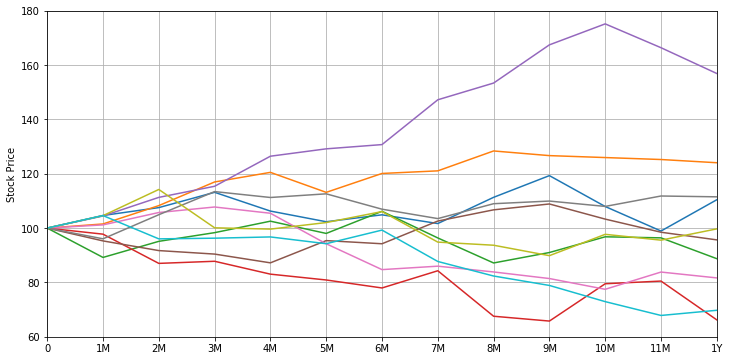

In [5]:
ts = np.linspace(0, 1, 13)
npaths = 10000
paths = blackscholes_mc(S, vol, r, q, ts=ts, npaths=npaths)
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(ts, paths[:, :10])
ax.set_xticks(ts)
ax.set_xticklabels(['0', '1M', '2M', '3M', '4M', '5M', '6M', '7M', '8M', '9M', '10M', '11M', '1Y'])
ax.set_ylabel('Stock Price')
ax.grid(True)

### Price of Bermudan put option with monthly exercises

In [6]:
def blackscholes_price(K, T, S, vol, r=0, q=0, callput='call'):
    """Compute the call/put option price in the Black-Scholes model
    
    Parameters
    ----------
    K: scalar or array_like
        The strike of the option.
    T: scalar or array_like
        The maturity of the option, expressed in years (e.g. 0.25 for 3-month and 2 for 2 years)
    S: scalar or array_like
        The current price of the underlying asset.
    vol: scalar or array_like
        The implied Black-Scholes volatility.
    r: scalar or array_like
        The annualized risk-free interest rate, continuously compounded.
    q: scalar or array_like
        The annualized continuous dividend yield.
    callput: str
        Must be either 'call' or 'put'.

    Returns
    -------
    price: scalar or array_like
        The price of the option.

    Examples
    --------
    >>> blackscholes_price(95, 0.25, 100, 0.2, r=0.05, callput='put')
    1.5342604771222823
    """
    F = S*np.exp((r-q)*T)
    v = np.sqrt(vol**2*T)
    d1 = np.log(F/K)/v + 0.5*v
    d2 = d1 - v
    try:
        opttype = {'call':1, 'put':-1}[callput.lower()]
    except:
        raise ValueError('The value of callput must be either "call" or "put".')
    price = opttype*(F*norm.cdf(opttype*d1)-K*norm.cdf(opttype*d2))*np.exp(-r*T)
    return price

<b>Question</b>. Oftentimes parametric regressions may not produce globally accurate estimates of continuation values for all possible values of state variables. One approach to improve the accuracy is to run regression only in the region where option is in the money. When the option is out of money, one should always choose to continue, therefore there is no need to estimate the continuation value.

Modify the Longstaff-Schwartz code to implement this improvement. <br> <br>
<b>(a).</b> Use quadratic polynomial basis functions;

<b>(b).</b> Use the constant 1.0 and the Black-Scholes price of a European put option with volatility $\bar\sigma = 0.2$ and maturity $T-t$ as the two basis functions at time $t$.

For each case, identify and plot the exercise and continuation regions at time $t=0.5$.

Quadratic polynomial basis functions
5.199921772049643


Blackscholes put price and Constant basis functions
5.2682530798736815


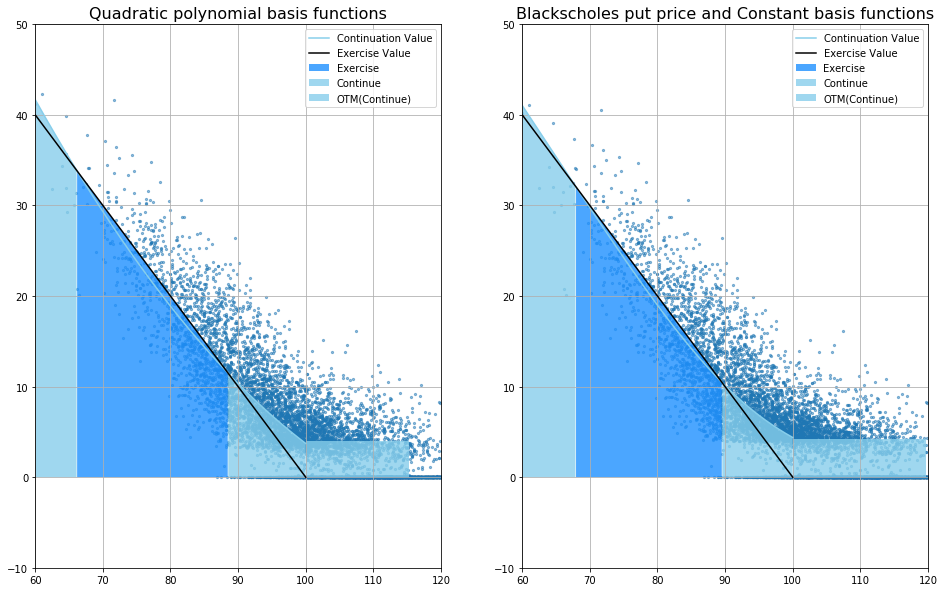

In [7]:
# Quadratic polynomial basis functions
fig, axes = plt.subplots(1, 2, figsize=(16 , 10))
payoff = np.maximum(K-paths[-1], 0)
for i in range(len(ts)-2, 0, -1):
    discount = np.exp(-r*(ts[i+1]-ts[i]))
    payoff = payoff*discount
    ind = paths[i] < K # index of in-the-money spot
    p = np.polyfit(paths[i, ind], payoff[ind], deg=2) # fit only on in-the-money spot
    contval = payoff.copy()
    contval[ind] = np.polyval(p, paths[i, ind])
    exerval = np.maximum(K-paths[i], 0)
    if i == 6:
        x = np.linspace(paths[i].min(), K, 500)
        x2 = np.linspace(100, 200, 500)
        y1 = np.polyval(p, x)
        y2 = np.maximum(K-x, 0)
        axes[0].scatter(paths[i], payoff, alpha=0.5, s = 5)
        axes[0].plot(x, y1, 'skyblue', label='Continuation Value')
        axes[0].plot(x, y2, 'k', label='Exercise Value')
        axes[0].fill_between(x, y2, where=y2 > y1, facecolor='dodgerblue', alpha=0.8, label='Exercise')
        axes[0].fill_between(x, y1, where=y1 >= y2, facecolor='skyblue', alpha=0.8, label='Continue')
        axes[0].fill_between(x2, 3.96, where=y1 >= y2, facecolor='skyblue', alpha=0.8, label='OTM(Continue)')
        axes[0].set_xlim([60,120])
        axes[0].set_ylim([-10,50])
        axes[0].legend(loc=0)
        axes[0].set_title('Quadratic polynomial basis functions', fontsize=16)
    # identify the paths where we should exercise    
    payoff[ind] = np.maximum(contval[ind], exerval[ind])
print ("Quadratic polynomial basis functions")
print (np.mean(payoff*np.exp(-r*(ts[1]-ts[0]))))

# Constant 1 and Blackscholes put price basis functions
payoff = np.maximum(K-paths[-1], 0)
for i in range(len(ts)-2, 0, -1):
    discount = np.exp(-r*(ts[i+1]-ts[i]))
    payoff = payoff*discount
    ind = paths[i] < K # index of in-the-money spot
    A = np.vstack((np.ones_like(paths[i, ind], dtype=np.float),
                   blackscholes_price(K, ts[-1]-ts[i], paths[i, ind], 0.2, r, q, callput='put'))).T
    p = np.linalg.lstsq(A, payoff[ind], rcond=None)[0] # fit only on in-the-money spot
    contval = payoff.copy()
    contval[ind] = np.ones_like(paths[i, ind], dtype=np.float)*p[0] + blackscholes_price(K, ts[-1]-ts[i], paths[i, ind], 0.2, r, q, callput='put')*p[1]
    exerval = np.maximum(K-paths[i], 0)
    if i == 6:
        x = np.linspace(paths[i].min(), K, 500)
        x2 = np.linspace(100, 200, 500)
        y1 = np.ones_like(x, dtype=np.float)*p[0] + blackscholes_price(K, ts[-1]-ts[i], x, 0.2, r, q, callput='put')*p[1]
        y2 = np.maximum(K-x, 0)
        axes[1].scatter(paths[i], payoff, alpha=0.5, s = 5)
        axes[1].plot(x, y1,
                'skyblue', label='Continuation Value')
        axes[1].plot(x, y2, 'k', label='Exercise Value')
        axes[1].fill_between(x, y2, where=y2 > y1, facecolor='dodgerblue', alpha=0.8, label='Exercise')
        axes[1].fill_between(x, y1, where=y1 >= y2, facecolor='skyblue', alpha=0.8, label='Continue')
        axes[1].fill_between(x2, 4.26, where=y1 >= y2, facecolor='skyblue', alpha=0.8, label='OTM(Continue)')
        axes[1].set_xlim([60,120])
        axes[1].set_ylim([-10,50])
        axes[1].legend(loc=0)
        axes[1].set_title('Blackscholes put price and Constant basis functions', fontsize=16)
    # identify the paths where we should exercise    
    payoff[ind] = np.maximum(contval[ind], exerval[ind])
print("\n")
print ("Blackscholes put price and Constant basis functions")
print (np.mean(payoff*np.exp(-r*(ts[1]-ts[0]))))

<b>Question</b>. [Multiple Exercises] Consider a chooser put option that allows its holder to exercise the option up to 3 times among 12 possible monthly exercise dates
$t_1=\frac{1}{12}, t_2=\frac{2}{12}, \cdots, t_{12}=1$.
If exercised at time $t_i$, the option holder is paid $\left(K-S_{t_i}\right)^+$ with $K=100$. No repetitive exercise at the same exercise date is allowed.
The underlying security price is assumed to follow the geometric Brownian motion

$$\frac{dS_t}{S_t}=(r-q)dt+\sigma dW_t$$

with $S_0=100$, $r=0.06$, $q=0.02$ and $\sigma=0.2$.

Modify the Longstaff-Schwartz algorithm for Bermudan option to price this chooser option.

<ul>
<li> Use quadratic polynomial basis functions in the regression
<li> The polynomial regression usually give poor global performance. To improve the accuracy, the regression should be done only in the region where option is in the money
<li> After the estimations of continuation values from the Longstaff-Schwartz algorithm are obtained, run an independent Monte Carlo simulation to obtain a low-biased price.
</ul>

In [8]:
def chooser_value(discount, values, ps1, ps2, paths, opps, t, K):
    """Compute the simulated value of chooser option at V(t, opps)
    
    Parameters
    ----------
    discount: scalar
        The discount factor.
    values: list of list.
        The value of chooser option at each time t and each exercise opportunity.
    ps1: list of ndarray.
        The regression coefficients of continuation value at each time t and each exercise opportunity.
    ps2: list of ndarray.
        The regression coefficients of exercise value at each time t and each exercise opportunity.
    paths: ndarray
        The simulated stick price.
    opps: scalar
        The exercise opportunity.
    t: scalar
        Time t.
    K: scalar
        Strike price.

    Returns
    -------
    value: ndarray
        The value of chooser option at V(t, opps).
    """
    
    # If exercise opportunities = 0, return 0
    # If t = 12 and exercise opportunities != 0, return the payoff at time T
    # Else calulate the value
    if opps == 0:
        return np.zeros_like(paths[0], dtype=np.float)
    elif t == 12:
        return np.maximum(K-paths[-1], 0)
    else:
        # Continuation Value
        payoff_1 = values[opps-1][t+1]*discount # Retrieve previously calculated value
        ind = paths[t] < K
        p1 = np.polyfit(paths[t,ind], payoff_1[ind], deg=2)
        ps1[opps-1][t] = p1 # Store the coefficients
        v1 = payoff_1.copy()
        v1[ind] = np.polyval(p1, paths[t,ind])
        
        # Exercise Value
        payoff_2 = chooser_value(discount, values, ps1, ps2, paths, opps-1, t+1, K)*discount
        v2 = payoff_2.copy()
        # Regress only when the value is not a zero vector
        if (opps-1) != 0:
            p2 = np.polyfit(paths[t,ind], payoff_2[ind], deg=2)
            ps2[opps-1][t] = p2
            v2[ind] = np.polyval(p2, paths[t,ind]) + np.maximum(K-paths[t, ind], 0)

        v = np.maximum(v1, v2)
        values[opps-1][t] = v # Update the value table
        return v

S = 100
vol = 0.2
r = 0.06
q = 0.02
K = 100
T = 1
ts = np.linspace(0, 1, 13)

# Original Paths
npaths = 10000
paths = blackscholes_mc(S, vol, r, q, ts=ts, npaths=npaths)
payoff = np.maximum(K-paths[-1], 0) # Payoff at time T
v = paths.copy() # Construct a table with the same size as paths to store values at each time t
v[12] = payoff   # Set the value at time T as payoff at time T
values = [v,v.copy(),v.copy()] # Construct a list to store the values when exercise opportunities = 1, 2, 3

# Coefficients list for continuation value and exercise value when exercise opportunities = 1, 2, 3
ps1 = [[[] for n in range(12)] for i in range(3)]    
ps2 = [[[] for n in range(12)] for i in range(3)]

# Recursively calling chooser_value to get the final value
for i in range(len(ts)-2, 0, -1):
    discount = np.exp(-r*(ts[i+1]-ts[i]))
    payoff = chooser_value(discount, values, ps1, ps2, paths, 3, i, K)

print ("Estimated: " + str(np.mean(payoff*np.exp(-r*(ts[1]-ts[0])))))


# Independent 100000 Paths
npaths = 100000
paths2 = blackscholes_mc(S, vol, r, q, ts=ts, npaths=npaths)
exer = np.zeros_like(paths2[0], dtype=np.int) # Record the exercise opportunities
exer[:] = 3 # Default to 3

value = 0.0
for i in range(1, len(ts)):
    if i==12:
        payoff = np.maximum(K-paths2[-1], 0)
        # identify the paths where we should exercise
        ind = exer > 0
        value = value + np.sum(payoff[ind]*np.exp(-r*(ts[-1]-ts[0])))
    else:
        # Default to zero for excercise opp = 0
        contval = np.zeros_like(exer, dtype=np.float)
        exerval = np.zeros_like(exer, dtype=np.float)
        
        # Check exer for how many excercise opps left and regress using the stored coefficients
        for opps in range(1,4):
            ind = (exer==opps)
            contval[ind] = np.polyval(ps1[opps-1][i], paths2[i,ind])
            if opps != 1:
                exerval[ind] = np.polyval(ps2[opps-1][i], paths2[i,ind]) + np.maximum(K-paths2[i,ind], 0)
            else:
                exerval[ind] = np.maximum(K-paths2[i,ind], 0)

        payoff = np.maximum(K-paths2[i],0)
        ind = exerval > contval
        hold = ind.copy()
        hold[exer==0] = 0
        exer[hold] = exer[hold]-1
        value = value + np.sum(payoff[hold]*np.exp(-r*(ts[i]-ts[0])))
print ("Low-Baised: " + str(value / 100000))

Estimated: 18.109046463786367
Low-Baised: 17.250015564809978


<b>Question</b>. Use the Longstaff-Schwartz algorithm to price an Bermudan-Asian call option. The underlying security price is assumed to follow the geometric Brownian motion

$$\frac{dS_t}{S_t}=(r-q)dt+\sigma dW_t$$

with $S_0=100$, $r=0$, $q=0$ and $\sigma=0.2$. The option has a strike of $K=100$ and a final expiration date of $T=1$ and can be exercised every month before the final maturity, i.e.
$$t_1=\frac{1}{12},\, t_2=\frac{2}{12},\, \ldots,\, t_{12}=1$$

The cashflow from exercising the option at time $t_n$, $n=1,\ldots,12$, is $\max\left(0, A_{t_n}-K\right)$ with $A_{t_n}=\frac{1}{n}\sum_{i=1}^nS_{t_i}$.

As the basis functions in the regression at time $t_n$, use the constant 1.0 and the Black-Scholes value of a European call option with strike $K$, maturity $T-t_n$, and volatility $\bar\sigma = 0.1$, written on
$$
Z_{t_n}\equiv \frac{nA_{t_n}+(12-n)S_{t_n}}{12}
$$

After the estimations of continuation values from the Longstaff-Schwartz algorithm are obtained, run an independent Monte Carlo simulation with at least 100000 paths to obtain a low-biased price.

In [9]:
S = 100
vol = 0.2
r = 0.0
q = 0.0
K = 100
T = 1
ts = np.linspace(0, 1, 13)
npaths = 10000
paths = blackscholes_mc(S, vol, r, q, ts=ts, npaths=npaths)
npaths = 100000
paths2 = blackscholes_mc(S, vol, r, q, ts=ts, npaths=npaths)

payoff = np.maximum(np.mean(paths[1:], axis=0)-K, 0)
ps = [[] for n in range(12)] # Coefficients list for continuation value
for i in range(len(ts)-2, 0, -1):
    discount = np.exp(-r*(ts[i+1]-ts[i]))
    payoff = payoff*discount
    Z = (np.sum(paths[1:i+1], axis=0) + (12-i)*paths[i]) / 12.0
    A = np.vstack((np.ones_like(Z, dtype=np.float),
                   blackscholes_price(K, ts[-1]-ts[i], Z, 0.1, r, q, callput='call'))).T
    p = np.linalg.lstsq(A, payoff, rcond=None)[0]
    ps[i] = p # Store the coefficients
    contval = np.ones_like(Z, dtype=np.float)*p[0] + blackscholes_price(K, ts[-1]-ts[i], Z, 0.1, r, q, callput='call')*p[1]
    exerval = np.maximum(np.mean(paths[1:i+1], axis=0)-K, 0)
    # identify the paths where we should exercise
    ind = exerval > contval
    payoff[ind] = exerval[ind]
print ("Estimated: " + str(np.mean(payoff*np.exp(-r*(ts[1]-ts[0])))))

# Independent 100000 Paths
exer = np.zeros_like(paths2[0], dtype=np.bool) # 1 if exercised, 0 if not yet exercised
value = 0.0
for i in range(1, len(ts)):
    if i==12:
        exerval = np.maximum(np.mean(paths2[1:], axis=0)-K, 0)
        # Exercise those not yet exercised
        value = value + np.sum(exerval[~exer]*np.exp(-r*(ts[-1]-ts[0])))
    else:
        Z = (np.sum(paths2[1:i+1], axis=0) + (12-i)*paths2[i]) / 12.0
        contval = np.ones_like(Z, dtype=np.float)*ps[i][0] + blackscholes_price(K, ts[-1]-ts[i], Z, 0.1, r, q, callput='call')*ps[i][1]
        exerval = np.maximum(np.mean(paths2[1:i+1], axis=0)-K, 0)
        # identify the paths where we should exercise
        ind = exerval > contval
        hold = ind.copy()
        hold[ind==exer] = 0 # If already exercised, set to 0
        exer[exer<ind] = 1  # Update the exer value
        value = value + np.sum(exerval[hold]*np.exp(-r*(ts[i]-ts[0])))
print ("Low-Baised: " + str(value / 100000))

Estimated: 5.314465054425575
Low-Baised: 5.310062556914577
